In [243]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [244]:
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY2.csv'
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ

    # waveform_csv = np.array(iq_val[:230401])    # 10 ms
    waveform_csv = np.array(iq_val)

print('len_waveform_csv', len(waveform_csv), 'waveform_csv', waveform_csv)

len_waveform_csv 460801 waveform_csv [ 9.300124e-05-3.206314e-04j -6.210618e-05-1.614263e-04j
  5.795475e-05+1.031473e-04j ...  1.002554e-04-1.394682e-06j
 -1.262527e-04-1.457361e-04j -1.681095e-04+2.749801e-04j]


In [245]:
# downsampling, low pass filter
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')
# print("waveform after decimate:",waveform[:5])

# scale up max amplitude to 1
waveform /= max(waveform.real.max(), waveform.imag.max())
# print("waveform scale max amplitude to 1:",waveform[:5])
print('len_waveform', len(waveform), 'waveform', waveform)

sampleRate = 23.04e6
sampleRateDS = sampleRate // dec_factor     # floor devision, sampleRate down sample  

len_waveform 57601 waveform [ 0.00503103-9.02849773e-04j  0.00184944+3.56987802e-03j
 -0.00732378-1.72590451e-02j ...  0.00389096+5.46480089e-05j
  0.00705551-5.35550362e-03j  0.00296097-4.31195814e-04j]


In [246]:
# add SNR to the waveform
# SC polar decoder can decode this when repeated bits in nrRateMatchPolar() are used
np.random.seed(69)
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5)) * 0.8
SNR = 10*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

SNR = -2.8151817456045847 dB


In [247]:
nrbSSB = 20
scsSSB = 30
searchBW = 6*scsSSB

# shift by half scs step
fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2
print('len_fshifts', len(fshifts), 'fshifts:', fshifts)

t = np.arange(len(waveform))/sampleRateDS
# print('len_t', len(t),'t',t)

len_fshifts 13 fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]


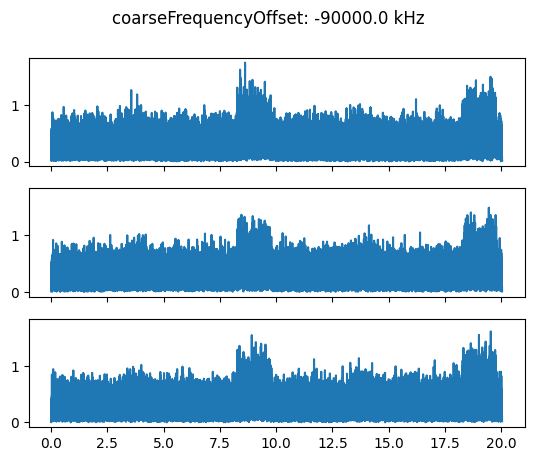

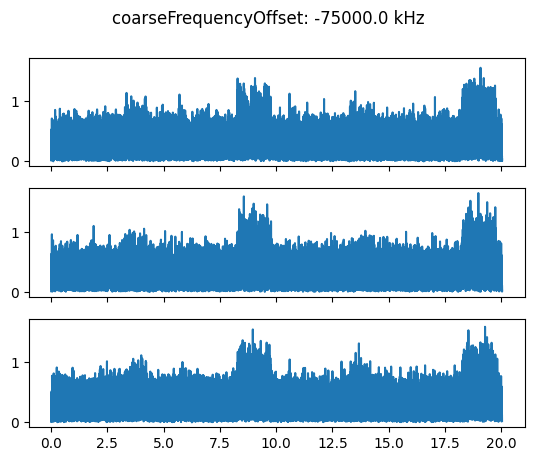

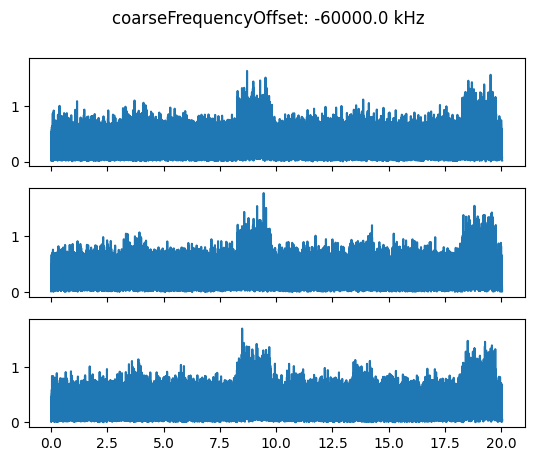

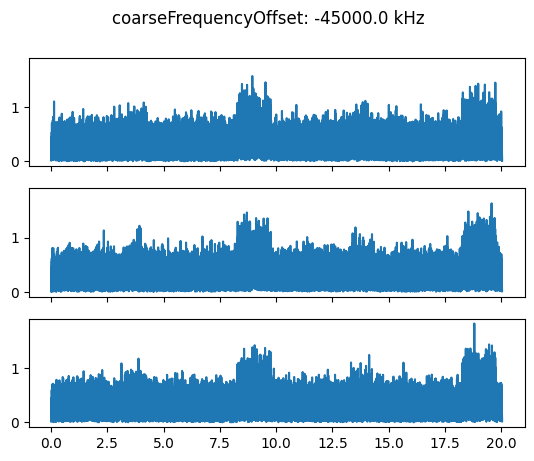

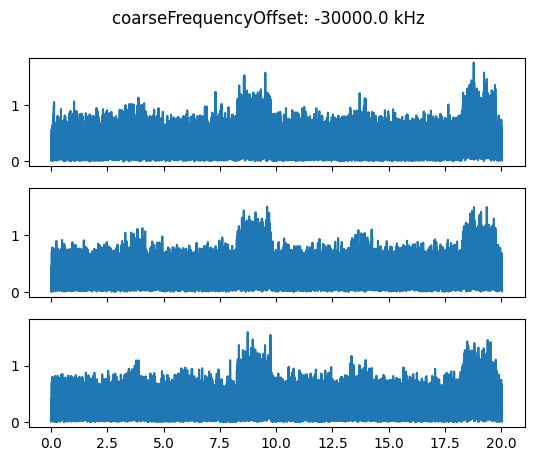

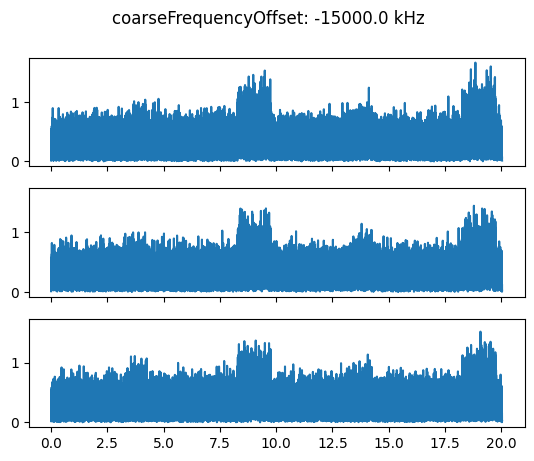

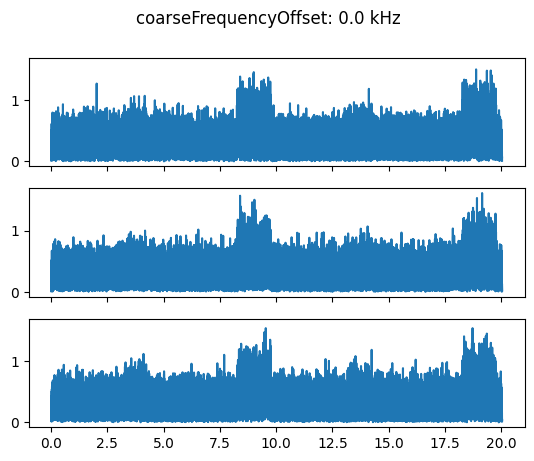

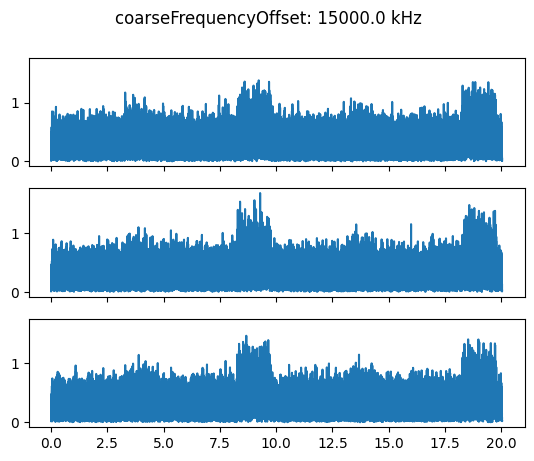

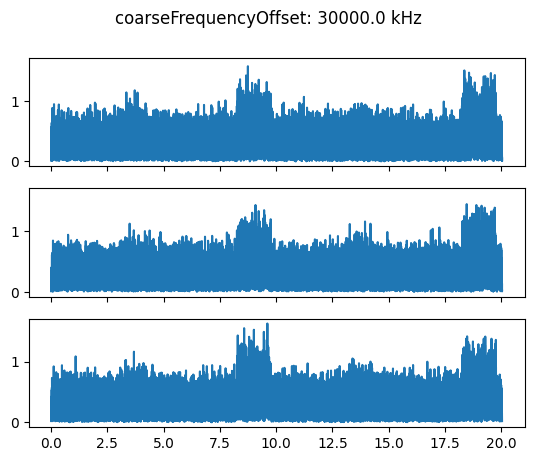

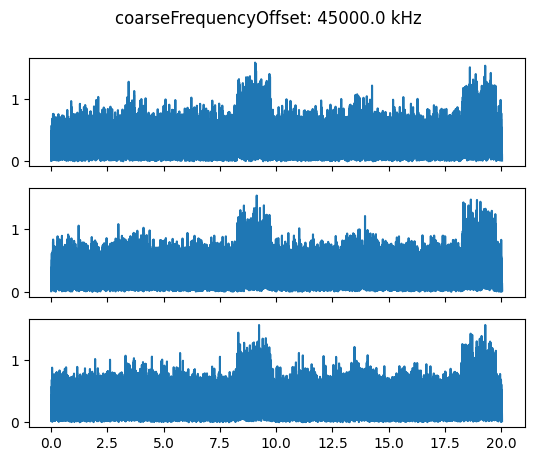

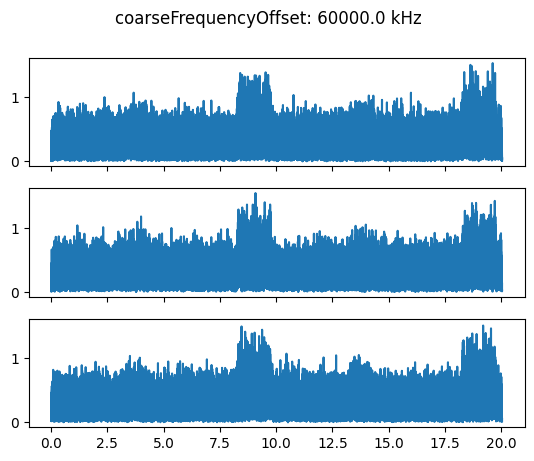

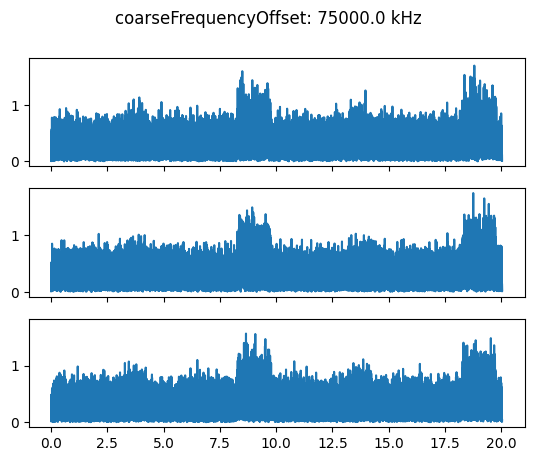

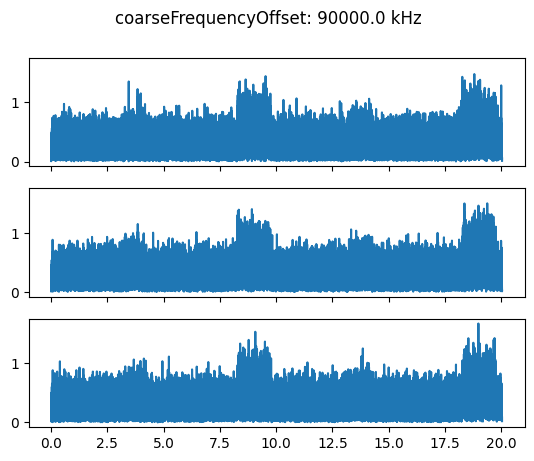

In [248]:
# it will always be the same, no need to stay in the loop
carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']         # scs = 30kHz, Nfft = 512

kPSS = np.arange(56, 183)

peak_value = np.zeros((len(fshifts),3))
peak_index = np.zeros((len(fshifts),3), 'int')

# loop on fshifts
for fshifts_index in np.arange(len(fshifts), dtype='int'):
    coarseFrequencyOffset = fshifts[fshifts_index]
    # print('coarseFrequencyOffset:', coarseFrequencyOffset)

    # shift frequency by coarseFrequencyOffset
    rxWaveformFrquencyCorrect = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
    nSlot = 0
    T = len(rxWaveformFrquencyCorrect)

    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:,1]

    # loop on NID2
    fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
    fig.suptitle(f"coarseFrequencyOffset: {coarseFrequencyOffset} kHz")
    for current_NID2 in np.arange(3, dtype='int'):
        # current_NID2 = 1
        slotGrid[kPSS] = nrPSS(current_NID2)        # at slot index KPSS assign value nrPSS(current_NID2)
        # generate refWaveform by modulate signal on carrier and slotGrid with assigned nrPSS
        [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
        refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

        # cross correlate waveform with refWaveform
        temp = scipy.signal.correlate(rxWaveformFrquencyCorrect, refWaveform)
        t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3

        # record magnitude 
        peak_index[fshifts_index, current_NID2] = np.argmax(np.abs(temp))
        peak_value[fshifts_index, current_NID2] = np.abs(temp[peak_index[fshifts_index, current_NID2]])

        # plot result, number of display figure = len(fshifts)s
        axs[current_NID2].plot(t_corr, np.abs(temp))

# print(peak_index)
# print(peak_value)

In [249]:
max_corr = np.max(peak_value)
select_row = np.floor(np.argmax(peak_value) // 3)   
coarseFrequencyOffsetfreqOffset = fshifts[select_row]    
NID2 = np.argmax(peak_value[select_row,:])

print("max_corr", max_corr)
print("coarseFrequencyOffsetfreqOffset", coarseFrequencyOffsetfreqOffset, "NID2", NID2)

peak_value

max_corr 1.8171284904470637
coarseFrequencyOffsetfreqOffset -45000.0 NID2 2


array([[1.74587338, 1.48828236, 1.60669806],
       [1.55933802, 1.64531307, 1.59096584],
       [1.62648191, 1.77623086, 1.68535045],
       [1.57061474, 1.62789793, 1.81712849],
       [1.74224809, 1.50357749, 1.5904257 ],
       [1.65469258, 1.44255537, 1.51868558],
       [1.50204689, 1.61227412, 1.53647358],
       [1.37734768, 1.67834784, 1.47024001],
       [1.56686917, 1.44426528, 1.62618215],
       [1.57808706, 1.53832646, 1.55467971],
       [1.53705399, 1.54502493, 1.51342607],
       [1.68882622, 1.74178514, 1.56445236],
       [1.47742203, 1.4970176 , 1.67071834]])